## MIT with integrated spatio-channel convs

In [1]:
import anndata
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import RandomResizedCrop, Compose, RandomHorizontalFlip, RandomVerticalFlip, Resize

from torch.utils.data import DataLoader
from tqdm import tqdm

# from functools import partial
from typing import Optional, Tuple, Type, Dict, List

from utils import DatasetFromTIFF, plot_markers, get_marker_names_map

In [2]:
import json

marker_map = json.load(open('tokenizer_vocab.json'))
markers_names_map = {v: k for k, v in marker_map.items()}

In [3]:
class GlobalResponseNormalization(nn.Module):
    """Global Response Normalization (GRN) layer 
    from https://arxiv.org/pdf/2301.00808"""

    def __init__(self, dim, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # B, H, W, E = x.shape

        gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        nx = gx / (gx.mean(dim=-1, keepdim=True) + self.eps)
        return self.gamma * (x * nx) + self.beta + x


class ConvNextBlock(nn.Module):
    """ConvNext2 block"""
    def __init__(
            self,
            dim: int,
            inter_dim: int,
    ):
            super().__init__()
            self.conv1 = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
            self.ln = nn.LayerNorm(dim)
            self.conv2 = nn.Linear(dim, inter_dim) # equivalent to nn.Conv2d(dim, inter_dim, kernel_size=1)
            self.act = nn.GELU()
            self.grn = GlobalResponseNormalization(inter_dim)
            self.conv3 = nn.Linear(inter_dim, dim) # equivalent to nn.Conv2d(inter_dim, dim, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # B, H, W, E = x.shape
        residual = x
        x = x.permute(0, 3, 1, 2) # [B, E, H, W]
        x = self.conv1(x)
        x = x.permute(0, 2, 3, 1)  # [B, H, W, E]
        x = self.ln(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.conv3(x)
        x = x + residual

        return x


class MLP(nn.Module):
    """Standard MLP module"""
    def __init__(
            self, 
            embedding_dim: int,
            mlp_dim: int,
            mlp_bias: bool = True,
            act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim, bias=mlp_bias),
            act(),
            nn.Linear(mlp_dim, embedding_dim, bias=mlp_bias),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)


class SpatialConvs(nn.Module):
    """Spatial convolutional blocks (per channel/marker)"""

    def __init__(
        self,
        embedding_dim: int,
        num_conv_blocks: int = 1,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_conv_blocks (int): Number of spatial convolutional blocks.
        """
        super().__init__()

        self.spatial_conv_blocks = nn.ModuleList()
        for _ in range(num_conv_blocks):
            self.spatial_conv_blocks.append(
                ConvNextBlock(
                    dim=embedding_dim,
                    inter_dim=embedding_dim*4,
                )
            )
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # B, C, H, W, E = x.shape

        # flatten on channel and batch dimension
        # x = x.reshape(B * C, H, W, E) # [B * C, H, W, E]

        # Spatial convolutional blocks
        for block in self.spatial_conv_blocks:
            x = block(x)
        
        # x = x.reshape(B, C, H, W, E)

        return x


class SpatioChannelAttention(nn.Module):
    """Spatial convolutional blocks (per channel/marker) for computing Q, K, V
    and cross-channel attention on pixel level."""

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
        """
        super().__init__()
        self.num_heads = num_heads
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"
        head_dim = embedding_dim // num_heads
        self.scale = head_dim**-0.5

        self.conv_q = ConvNextBlock(dim=embedding_dim, inter_dim=4*embedding_dim)
        self.conv_k = ConvNextBlock(dim=embedding_dim, inter_dim=4*embedding_dim)
        self.conv_v = ConvNextBlock(dim=embedding_dim, inter_dim=4*embedding_dim)

        self.norm1 = nn.LayerNorm(head_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.proj = MLP(embedding_dim=embedding_dim, mlp_dim=2*embedding_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W, E = x.shape
        N_HEADS = self.num_heads
        shortcut = x

        def reshape_for_channel_attention(x: torch.Tensor) -> torch.Tensor:
            """Reshape input tensor for channel attention.

            Args:
                x (torch.Tensor): Input tensor with shape [B * C, H, W, E]

            Returns:
                torch.Tensor: Output tensor with shape [B * H * W, C, num_heads, E/num_heads]
            """
            x = x.reshape(B, C, H, W, E).permute(0, 2, 3, 1, 4).reshape(-1, C, E) # [B * H * W, C, E]
            x = x.reshape(B * H * W, C, N_HEADS, -1) # [B * H * W, C, num_heads, E/num_heads]
            return x

        
        def reshape_from_channel_attention(x: torch.Tensor) -> torch.Tensor:
            """Reshape input tensor from channel attention.

            Args:
                x (torch.Tensor): Input tensor with shape [B * H * W, C, num_heads, E/num_heads]

            Returns:
                torch.Tensor: Output tensor with shape [B, C, H, W, E]
            """
            x = x.reshape(B, H, W, C, N_HEADS, -1).permute(0, 3, 1, 2, 4, 5).reshape(B, C, H, W, E) # [B, C, H, W, E]
            return x

        # flatten on channel and batch dimension
        x = x.reshape(B * C, H, W, E) # [B * C, H, W, E]

        # Spatial convolutional blocks
        q = self.conv_q(x)
        k = self.conv_k(x)
        v = self.conv_v(x)

        q = reshape_for_channel_attention(q) # [B * H * W, C, num_heads, E/num_heads]
        k = reshape_for_channel_attention(k)
        v = reshape_for_channel_attention(v)

        # Cross-channel attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = (attn @ v) + q # add skip connection to q feature map
        x = self.norm1(x)
        x = reshape_from_channel_attention(x)
        x = self.proj(x)
        x = x + shortcut
        x = self.norm2(x)

        return x


class MultiplexBlock(nn.Module):
    """Multiplex Block integrating spatio-channel attention blocks."""

    def __init__(
        self,
        num_blocks: int,
        embedding_dim: int,
        num_heads: int,
    ) -> None:
        """
        Args:
            num_blocks (int): Number of attention blocks.
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each attention block.  
        """
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(
                SpatioChannelAttention(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                )
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x

        
class MultiplexImageEncoder(nn.Module):
    """Multiplex Image encoder integrating spatial and cross-channel blocks."""

    def __init__(
        self,
        layers_blocks: List[int],
        embedding_dims: List[int],
        num_heads: List[int],
        channel_embedding_dim: int,
        num_channels: int,
    ) -> None:
        """
        Args:
            layers_blocks (List[int]): Number of attention blocks in each layer.
            embedding_dims (List[int]): Number of input channels in each layer.
            num_heads (List[int]): Number of attention heads in each attention block.
            channel_embedding_dim (int): Embedding dimension per channel pixel.
            num_channels (int): Maximal number of channels/markers (vocab dim).
        """
        super().__init__()
        self.channel_embedder = nn.Embedding(num_channels, channel_embedding_dim)
        self.pixel_proj = nn.Linear(1, channel_embedding_dim)

        # self.stem = nn.Conv2d(channel_embedding_dim, embedding_dims[0], kernel_size=4, padding=0, stride=4)
        self.poolings = nn.ModuleList()
        self.poolings.append(
            nn.Conv2d(channel_embedding_dim, embedding_dims[0], kernel_size=2, padding=0, stride=2)
        )
        for i, out_dim in enumerate(embedding_dims[1:]):
            input_dim = embedding_dims[i]
            self.poolings.append(
                nn.Conv2d(input_dim, out_dim, kernel_size=2, padding=0, stride=2)
            )

        self.norms = nn.ModuleList()
        for dim in embedding_dims:
            self.norms.append(nn.BatchNorm2d(dim))
             
        self.layers = nn.ModuleList()
        for blocks, dim, heads in zip(layers_blocks, embedding_dims, num_heads):
            self.layers.append(
                MultiplexBlock(
                    num_blocks=blocks,
                    embedding_dim=dim,
                    num_heads=heads,
                )
            )
        

    def forward(self, x: torch.Tensor, channel_ids: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Multiplex Image Transformer.

        Args:
            x (torch.Tensor): Multiplex images batch tensor with shape [B, C, H, W]
            channel_ids (torch.Tensor): Channel ids tensor with shape [B, C]

        Returns:
            torch.Tensor: Embedding tensor
        """
        B, C, H, W = x.shape
        E = self.channel_embedder.embedding_dim

        channel_embeds = self.channel_embedder(channel_ids)
        x = x.unsqueeze(-1)  # [B, C, H, W, 1]
        channel_embeds = channel_embeds.unsqueeze(-2).unsqueeze(-2) # [B, C, 1, 1, E]

        # channel embedding
        x = self.pixel_proj(x) + channel_embeds # [B, C, H, W, E]

        # poolings and blocks
        for pooling, norm, layer in zip(self.poolings, self.norms, self.layers):
            x = x.reshape(B * C, H, W, E).permute(0, 3, 1, 2)
            x = norm(pooling(x))
            _, E, H, W = x.shape
            x = x.permute(0, 2, 3, 1).reshape(B, C, H, W, E)
            x = layer(x)

        return x


class MultiplexImageDecoder(nn.Module):
    """Decoder for MIT model restoring the original image shape, inspired by the one from FCMAE
    (see https://github.com/facebookresearch/ConvNeXt-V2/blob/main/models/fcmae.py)"""
    
    def __init__(
            self,
            input_embedding_dim: int,
            decoded_embed_dim: int,
            num_heads: int,
            num_blocks: int,
            scaling_factor: int,
        ) -> None:
            """
            Args:
                input_embedding_dim (int): Embedding dimension of the input tensor.
                decoded_embed_dim (int): Embedding dimension of the decoded tensor (before last projections).
                num_heads (int): Number of attention heads in each attention.
                num_blocks (int): Number of multiplex blocks in each intermediate layer.
                scaling_factor (int): Scaling factor for the upsampling.
            """
            super().__init__()
            self.scaling_factor = scaling_factor
            self.proj = nn.Linear(input_embedding_dim, decoded_embed_dim) # input projection
            self.decoder = MultiplexBlock(
                num_blocks=num_blocks,
                embedding_dim=decoded_embed_dim,
                num_heads=num_heads,
            )

            self.pred = nn.Linear(decoded_embed_dim, scaling_factor**2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Multiplex Image Decoder.

        Args:
            x (torch.Tensor): Input tensor (embedding).

        Returns:
            torch.Tensor: Reconstructed image tensor
        """
        B, C, H, W, E = x.shape
        x = self.proj(x)
        x = self.decoder(x)
        x = self.pred(x)
        x = x.view(B, C, H, W, self.scaling_factor, self.scaling_factor)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, H*self.scaling_factor, W*self.scaling_factor)

        return x


class MultiplexImageTransformer(nn.Module):
    """Multiplex Image Transformer model combining encoder and decoder."""

    def __init__(
        self,
        num_channels: int,
        channel_embedding_dim: int,
        encoder_layers_blocks: List[int],
        encoder_embedding_dims: List[int],
        encoder_num_heads: List[int],
        decoder_dim: int,
        decoder_blocks_num: int,
        decoder_num_heads: int,
    ) -> None:
        """
        Args:
            num_channels (int): Maximal number of channels/markers (vocab dim).
            channel_embedding_dim (int): Embedding dimension per channel pixel.
            encoder_layers_blocks (List[int]): Number of multiplex blocks in each layer.
            encoder_embedding_dims (List[int]): Input embedding dimensions in each layer.
            encoder_num_heads (List[int]): Number of attention heads in each multiplex block.
            channel_embedding_dim (int): Embedding dimension per channel pixel.
            decoder_dim (int): Embedding dimension of the decoded tensor (before last projections).
            decoder_blocks_num (int): Number of multiplex blocks in the decoder.
            decoder_num_heads (int): Number of attention heads in each multiplex block.
        """

        super().__init__()
        

        self.encoder = MultiplexImageEncoder(
            layers_blocks=encoder_layers_blocks,
            embedding_dims=encoder_embedding_dims,
            channel_embedding_dim=channel_embedding_dim,
            num_heads=encoder_num_heads,
            num_channels=num_channels,
        )

        self.decoder = MultiplexImageDecoder(
            input_embedding_dim=encoder_embedding_dims[-1],
            decoded_embed_dim=decoder_dim,
            num_blocks=decoder_blocks_num,
            scaling_factor=2**(len(encoder_layers_blocks)),
            num_heads=decoder_num_heads,
        )
    
    def forward(self, x: torch.Tensor, channel_ids: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the Multiplex Image Transformer.

        Args:
            x (torch.Tensor): Input image tensor.
            channel_ids (torch.Tensor): Input channel ids tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Reconstructed image tensor and encoder embedding tensor.
        """

        encoded_x = self.encoder(x, channel_ids)
        decoded_x = self.decoder(encoded_x)

        return decoded_x, encoded_x

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

In [5]:

def train(model, optimizer, train_dataloader, val_dataloader, device, epochs=10, gradient_accumulation_steps=1):
    model.train()
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (img, channel_ids) in enumerate(tqdm(train_dataloader)):
            img = img.to(torch.float32).to(device)
            channel_ids = channel_ids.to(device)
            output, _ = model(img, channel_ids)
            loss = criterion(output, img)
            loss.backward()
            if (i+1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            running_loss += loss.item()
                        
        print(f'Epoch {epoch} loss: {running_loss / len(train_dataloader)}')
        val_loss = test(model, val_dataloader, device)
        print(f'Validation loss: {val_loss}')

def test(model, test_dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    with torch.no_grad():
        for img, channel_ids in test_dataloader:
            img = img.to(torch.float32).to(device)
            channel_ids = channel_ids.to(device)
            output, _ = model(img, channel_ids)
            loss = criterion(output, img)
            running_loss += loss.item()
    return running_loss / len(test_dataloader)

In [6]:
TRAIN_DATA_PATH = '/Users/dawid/Desktop/uw/rok IV/sem VIII/DLLS/DeepLearningProject/data/train/images_masks/img'
TEST_DATA_PATH = '/Users/dawid/Desktop/uw/rok IV/sem VIII/DLLS/DeepLearningProject/data/test/images_masks/img'
VAL_DATA_PATH = '/Users/dawid/Desktop/uw/rok IV/sem VIII/DLLS/DeepLearningProject/data/val/images_masks/img'

SIZE = (112, 112)

train_transform = Compose([
        RandomResizedCrop(SIZE),
        RandomHorizontalFlip(0.5),
        RandomVerticalFlip(0.5)
])

test_transform = Resize(SIZE)

train_dataset = DatasetFromTIFF(TRAIN_DATA_PATH, transform=train_transform)
val_dataset = DatasetFromTIFF(VAL_DATA_PATH, transform=test_transform)
test_dataset = DatasetFromTIFF(TEST_DATA_PATH, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
train_anndata = anndata.read_h5ad('/Users/dawid/Desktop/uw/rok IV/sem VIII/DLLS/DeepLearningProject/data/train/cell_data.h5ad')
markers_names_map = get_marker_names_map(train_anndata)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

encoder_layers_blocks = [3, 3, 3]
encoder_embedding_dims = [96, 192, 384]
encoder_num_heads = [6, 6, 6]

decoder_dim = 192
decoder_blocks_num = 3
decoder_num_heads = 6

model = MultiplexImageTransformer(
    channel_embedding_dim=96,
    num_channels=40,
    encoder_layers_blocks=encoder_layers_blocks,
    encoder_embedding_dims=encoder_embedding_dims,
    encoder_num_heads=encoder_num_heads,
    decoder_dim=decoder_dim,
    decoder_blocks_num=decoder_blocks_num,
    decoder_num_heads=decoder_num_heads,
).to(device)

In [9]:
lr = 5e-4
weight_decay = 0.01
gradient_accumulation_steps = 1
epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train(model, optimizer, train_dataloader, val_dataloader, device, epochs=epochs, gradient_accumulation_steps=gradient_accumulation_steps)

100%|██████████| 100/100 [42:08<00:00, 25.29s/it]


Epoch 0 loss: 0.012563632777892053
Validation loss: 0.003042896348051727


100%|██████████| 100/100 [42:15<00:00, 25.35s/it]


Epoch 1 loss: 0.002999215549789369
Validation loss: 0.0018550302251242102


100%|██████████| 100/100 [42:24<00:00, 25.44s/it]


Epoch 2 loss: 0.0018709561607101932
Validation loss: 0.0011616669269278645


100%|██████████| 100/100 [42:26<00:00, 25.46s/it]


Epoch 3 loss: 0.0012471333603025414
Validation loss: 0.00114847271470353


100%|██████████| 100/100 [41:47<00:00, 25.07s/it]


Epoch 4 loss: 0.001035957770072855
Validation loss: 0.001027732859365642


  0%|          | 0/100 [00:11<?, ?it/s]


KeyboardInterrupt: 

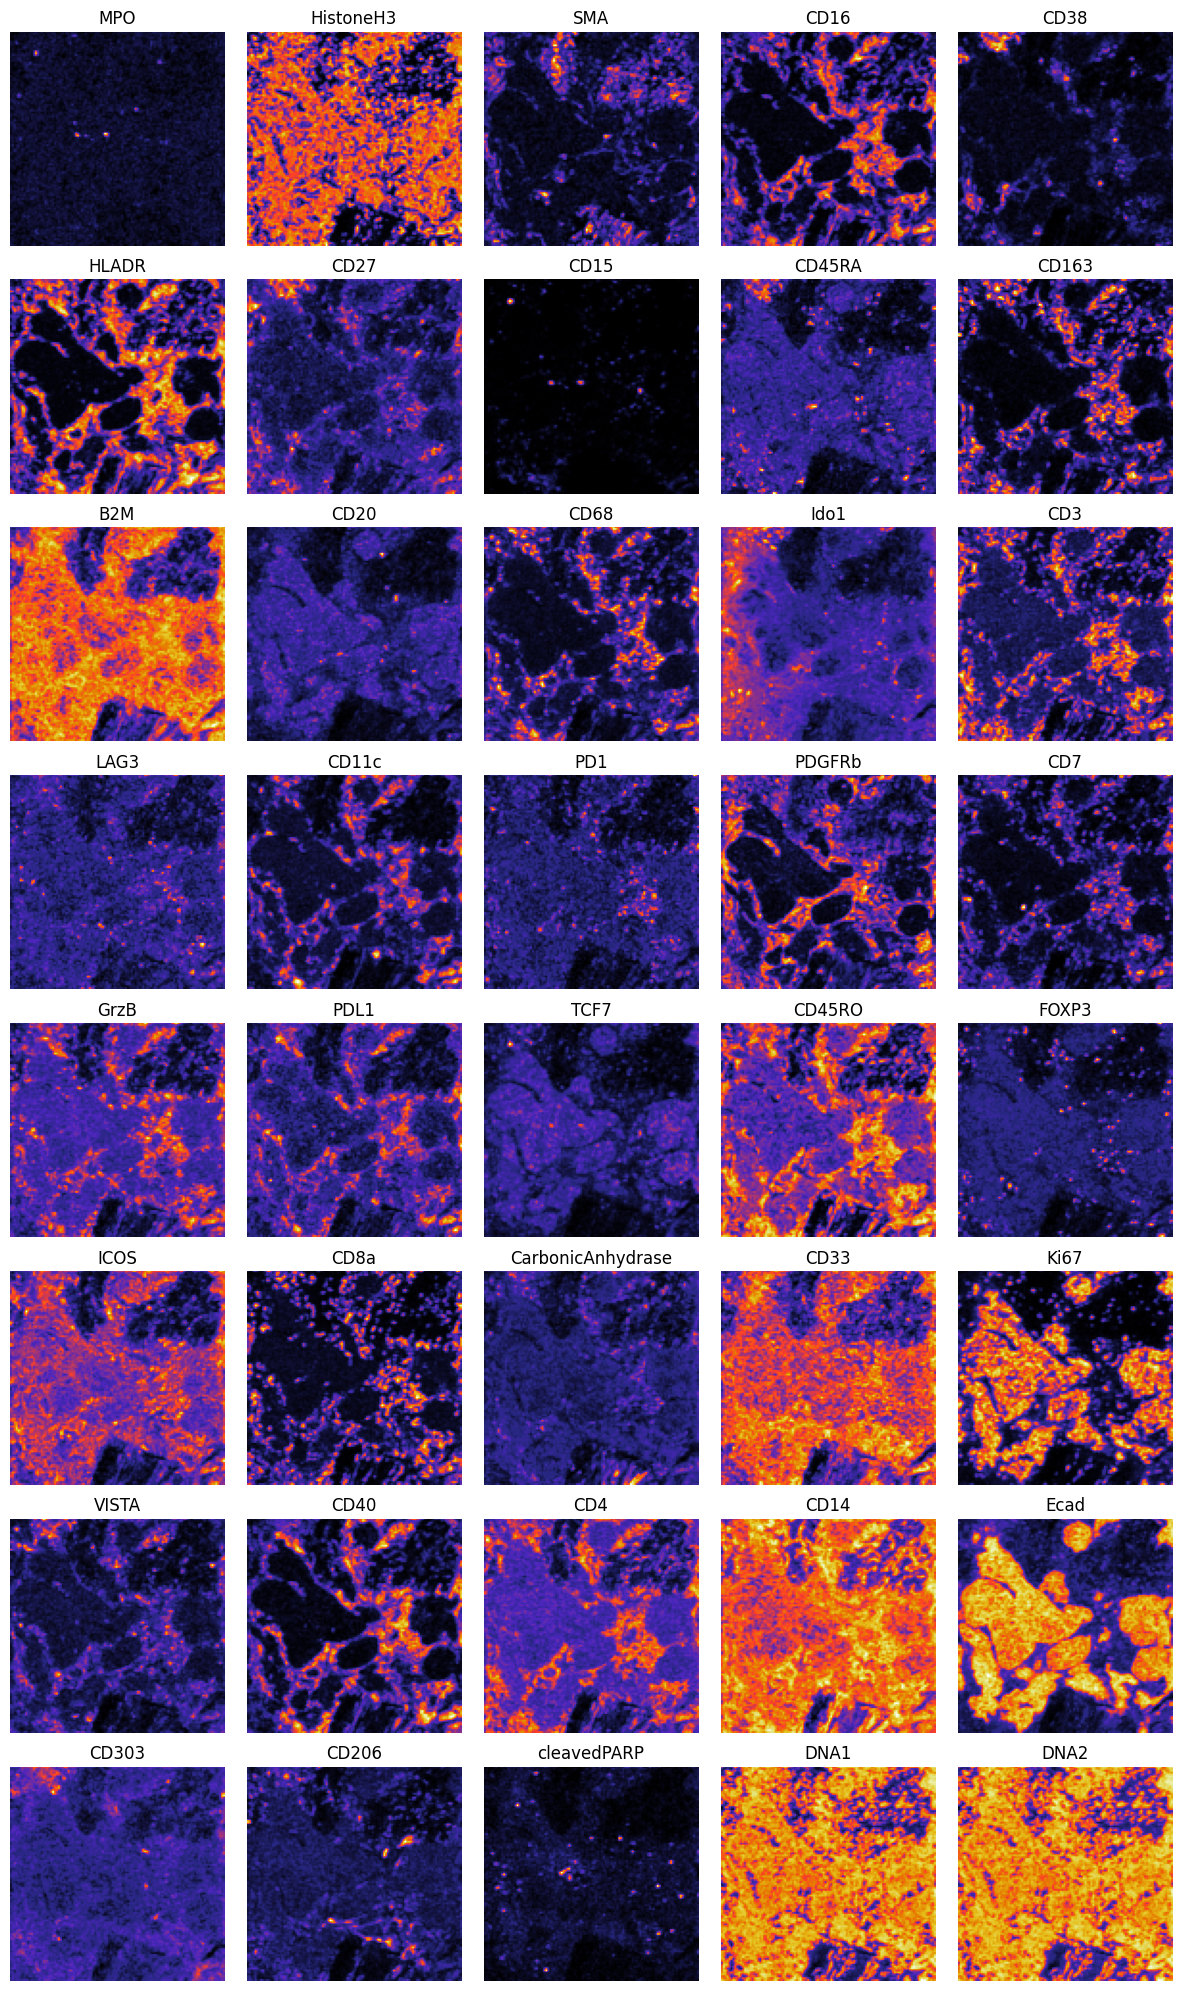

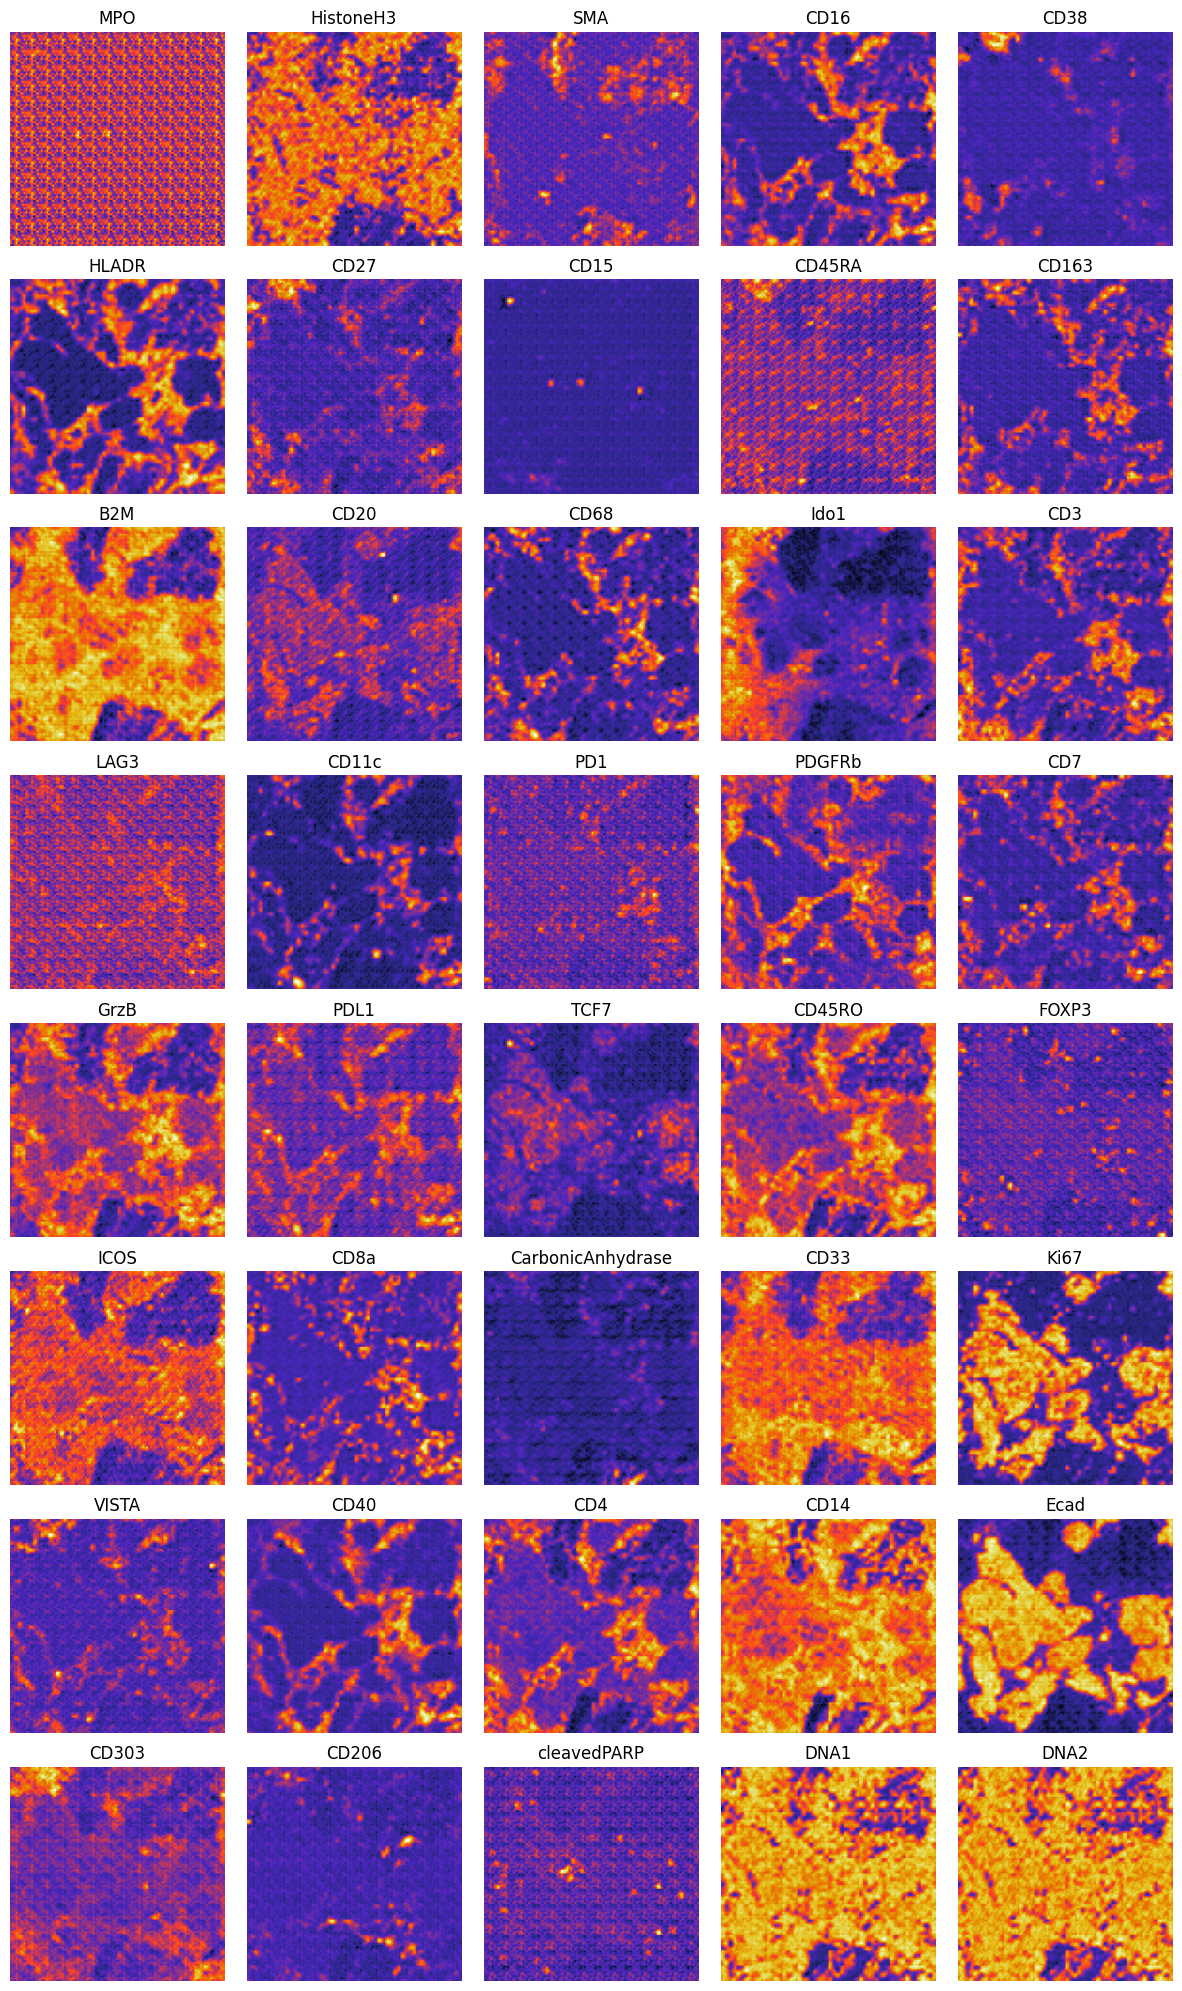

In [10]:
test_img, test_channel_ids = test_dataset[16]
test_img = test_img.to(torch.float32).to(device)
test_channel_ids = test_channel_ids.to(device)

test_img = test_img.unsqueeze(0)
test_channel_ids = test_channel_ids.unsqueeze(0)

with torch.no_grad():
    output, _ = model(test_img, test_channel_ids)

plot_markers(test_img.squeeze().cpu().numpy(), markers_names_map)
plot_markers(output.squeeze().cpu().numpy(), markers_names_map)